In [14]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
import os
import scipy.io
import matplotlib.pyplot as plt

In [2]:
url="https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar"
dataset = tf.keras.utils.get_file(
    "wiki_crop",url,
    untar=True,cache_dir='.',
    cache_subdir=''
)
dataset_dir = os.path.join(os.path.dirname(dataset),'wiki_crop')


In [3]:

mat = scipy.io.loadmat(os.path.join(dataset_dir,'wiki.mat'))
import numpy as np
import datetime
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Jan 16 16:25:20 2016',
 '__version__': '1.0',
 '__globals__': [],
 'wiki': array([[(array([[723671, 703186, 711677, ..., 720620, 723893, 713846]]), array([[2009, 1964, 2008, ..., 2013, 2011, 2008]], dtype=uint16), array([[array(['17/10000217_1981-05-05_2009.jpg'], dtype='<U31'),
                 array(['48/10000548_1925-04-04_1964.jpg'], dtype='<U31'),
                 array(['12/100012_1948-07-03_2008.jpg'], dtype='<U29'), ...,
                 array(['09/9998109_1972-12-27_2013.jpg'], dtype='<U30'),
                 array(['00/9999400_1981-12-13_2011.jpg'], dtype='<U30'),
                 array(['80/999980_1954-06-11_2008.jpg'], dtype='<U29')]],
               dtype=object), array([[1., 1., 1., ..., 1., 1., 0.]]), array([[array(['Sami Jauhojärvi'], dtype='<U15'),
                 array(['Dettmar Cramer'], dtype='<U14'),
                 array(['Marc Okrand'], dtype='<U11'), ...,
                 array(['Michael 

In [4]:
mat["wiki"]["dob"][0][0][0]

array([723671, 703186, 711677, ..., 720620, 723893, 713846])

In [5]:
dob = np.vectorize(lambda x:datetime.datetime.fromordinal(x).year)(
mat["wiki"]["dob"][0][0][0]
)
photo_taken = mat["wiki"]["photo_taken"][0][0][0]
age =(photo_taken-dob).astype(np.float32)
age

array([27., 38., 59., ..., 40., 29., 53.], dtype=float32)

In [6]:
mat["wiki"]["full_path"][0][0][0]

array([array(['17/10000217_1981-05-05_2009.jpg'], dtype='<U31'),
       array(['48/10000548_1925-04-04_1964.jpg'], dtype='<U31'),
       array(['12/100012_1948-07-03_2008.jpg'], dtype='<U29'), ...,
       array(['09/9998109_1972-12-27_2013.jpg'], dtype='<U30'),
       array(['00/9999400_1981-12-13_2011.jpg'], dtype='<U30'),
       array(['80/999980_1954-06-11_2008.jpg'], dtype='<U29')],
      dtype=object)

In [7]:
file_path = np.vectorize(lambda x: os.path.join(dataset_dir,x[0]))(
mat["wiki"]["full_path"][0][0][0]
)
file_path

array(['.\\wiki_crop\\17/10000217_1981-05-05_2009.jpg',
       '.\\wiki_crop\\48/10000548_1925-04-04_1964.jpg',
       '.\\wiki_crop\\12/100012_1948-07-03_2008.jpg', ...,
       '.\\wiki_crop\\09/9998109_1972-12-27_2013.jpg',
       '.\\wiki_crop\\00/9999400_1981-12-13_2011.jpg',
       '.\\wiki_crop\\80/999980_1954-06-11_2008.jpg'], dtype='<U49')

In [8]:
file_age_ds = tf.data.Dataset.from_tensor_slices((file_path,age))
def parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)
    image = tf.image.resize(image_decoded,[256,256])
    return image, tf.expand_dims(label,0)
image_age_ds=file_age_ds.map(parse_function).shuffle(seed=2,buffer_size=64)
image_age_ds

<_ShuffleDataset element_spec=(TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.float32, name=None))>

In [9]:
dataset_size = image_age_ds.cardinality().numpy()
AUTOTUNE = tf.data.AUTOTUNE
train_ds = image_age_ds.take(dataset_size*.6).batch(32).prefetch(AUTOTUNE)
val_ds =image_age_ds.skip(dataset_size*.6).take(dataset_size*.2).batch(32).prefetch(AUTOTUNE)
test_ds =image_age_ds.skip(dataset_size*.8).take(dataset_size*.2).batch(32).prefetch(AUTOTUNE)

In [10]:
model = tf.keras.Sequential([
tfl.Conv2D(32,(7,7),padding="valid",activation="relu",input_shape=(256,256,1)),
tfl.MaxPool2D((4,4),strides = 4),
tfl.Conv2D(64,(3,3),padding ="valid",activation="relu"),
tfl.MaxPool2D((4,4),strides = 4),
tfl.Conv2D(128,(3,3),padding ="valid",activation="relu"),
tfl.MaxPool2D((2,2),strides = 2),
tfl.Conv2D(256,(1,1),padding="valid",activation="relu",),
tfl.MaxPool2D((2,2),strides = 2),
tfl.Flatten(),
tfl.Dense(64,activation="relu"),
tfl.Dense(1)
])
model.summary()


C:\Users\chand\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 250, 250, 32)        │           1,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 60, 60, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 13, 13, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 256)           │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 274,561 (1.05 MB)

 Trainable params: 274,561 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.MeanAbsoluteError(),
    metrics=['MAE']
    )
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[
    tf.keras.callbacks.TensorBoard(log_dir="logs")
    ]
)

Epoch 1/5
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 362s 307ms/step - MAE: 15.7596 - loss: 15.7596 - val_MAE: 12.3645 - val_loss: 12.3645
Epoch 2/5
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 342s 292ms/step - MAE: 13.4450 - loss: 13.4450 - val_MAE: 12.1798 - val_loss: 12.1798
Epoch 3/5
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 342s 292ms/step - MAE: 12.7358 - loss: 12.7358 - val_MAE: 11.8188 - val_loss: 11.8188
Epoch 4/5
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 344s 294ms/step - MAE: 12.3828 - loss: 12.3828 - val_MAE: 12.0092 - val_loss: 12.0092
Epoch 5/5
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 338s 289ms/step - MAE: 12.2095 - loss: 12.2095 - val_MAE: 11.4148 - val_loss: 11.4148


In [12]:
loss,accuracy = model.evaluate(test_ds)
print("Loss:",loss)
print("Accuracy:",accuracy)

390/390 ━━━━━━━━━━━━━━━━━━━━ 47s 92ms/step - MAE: 11.5662 - loss: 11.5662
Loss: 11.777535438537598
Accuracy: 11.777535438537598


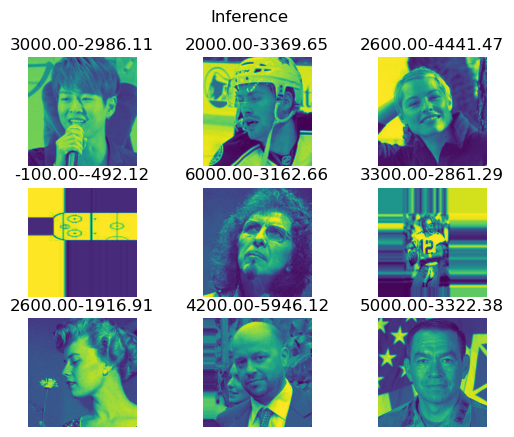

In [15]:
image, label = next(iter(val_ds))
images = image.numpy()[:9]
res = tf.squeeze(model(image))
label = tf.squeeze(label)
plt.suptitle("Inference")
for i,(img,r) in enumerate(zip(images,res)):
    plt.subplot(331+i)
    plt.title(f"{label[i]*100:.2f}-{res[i]*100:.2f}")
    plt.imshow(img)
    plt.axis("off")
plt.show()